In [16]:
import mne
import pandas as pd
import numpy as np

# Read data from "derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr"
data_raw=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/sub-xp101/eeg/sub-xp101_task-motorloc_eeg.vhdr')


Extracting parameters from C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/sub-xp101/eeg/sub-xp101_task-motorloc_eeg.vhdr...
Setting channel info structure...


In [ ]:
data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr')

In [17]:
%matplotlib tk

ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'qt' is currently running

In [18]:
data_raw.resample(200).plot()

Opening raw-browser...


In [3]:
data_filt=data.copy().load_data().filter(0.3,60)

Reading 0 ... 67387  =      0.000 ...   336.935 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 2201 samples (11.005 sec)



In [13]:

data_filt.plot()

Opening raw-browser...


In [4]:
data.ch_names #names of the channels of the EEG

['Fp1',
 'Fp2',
 'F3',
 'F4',
 'C3',
 'C4',
 'P3',
 'P4',
 'O1',
 'O2',
 'F7',
 'F8',
 'T7',
 'T8',
 'P7',
 'P8',
 'Fz',
 'Cz',
 'Pz',
 'Oz',
 'FC1',
 'FC2',
 'CP1',
 'CP2',
 'FC5',
 'FC6',
 'CP5',
 'CP6',
 'TP9',
 'TP10',
 'POz',
 'ECG',
 'F1',
 'F2',
 'C1',
 'C2',
 'P1',
 'P2',
 'AF3',
 'AF4',
 'FC3',
 'FC4',
 'CP3',
 'CP4',
 'PO3',
 'PO4',
 'F5',
 'F6',
 'C5',
 'C6',
 'P5',
 'P6',
 'AF7',
 'AF8',
 'FT7',
 'FT8',
 'TP7',
 'TP8',
 'PO7',
 'PO8',
 'FT9',
 'FT10',
 'Fpz',
 'CPz']

In [4]:
# Another way to extract the events, not used

#events=pd.read_table('C:/Users/ernes/Desktop/Master/Course 21-22/2nd term 21-22/Neuroimage/Week 6/task-motorloc_events.tsv')
#dummies=pd.get_dummies(events,columns=['trial_type']).drop(columns=['duration','trial_type_Rest'])
#dummies['onset']=dummies['onset']*200
#events=dummies.to_numpy()

In [4]:
events=mne.events_from_annotations(data_filt) #extract the events from the data
events 

Used Annotations descriptions: ['New Segment/', 'Pulse Artifact/R', 'Response/R128', 'Stimulus/S  1', 'Stimulus/S 99', 'TPULSE/TEND', 'TPULSE/TPEAK', 'TPULSE/TSTART']


(array([[    0,     0, 99999],
        [ 2230,     0,  1128],
        [ 2249,     0, 10001],
        ...,
        [67030,     0,  1128],
        [67075,     0, 10001],
        [67227,     0, 10001]]),
 {'New Segment/': 99999,
  'Pulse Artifact/R': 10001,
  'Response/R128': 1128,
  'Stimulus/S  1': 1,
  'Stimulus/S 99': 99,
  'TPULSE/TEND': 10002,
  'TPULSE/TPEAK': 10003,
  'TPULSE/TSTART': 10004})

In [5]:
#select events in the task blocks
blockstart=False
new_events=np.zeros([1,3],dtype=np.int16)
for i in range(len(events[0])):
    if events[0][i,2] == 1:
        blockstart=True
        j=1
    while blockstart and i+j<558:
        if events[0][i+j,2]==10001:
            curr_event=events[0][i+j]
            new_events=np.concatenate((new_events,np.expand_dims(curr_event,axis=0)),axis=0)
            
        if events[0][i+j,2]==99:
            blockstart=False
        j=j+1
new_events=new_events[1:]

In [6]:
#Create a new channel called stimulation (STI) needed to add the events
stim=mne.create_info(['STI'],200,['stim'])
stim_raw=mne.io.RawArray(np.zeros([1,67388]),stim)
data_filt.load_data().add_channels([stim_raw],force_update_info=True)

Creating RawArray with float64 data, n_channels=1, n_times=67388
    Range : 0 ... 67387 =      0.000 ...   336.935 secs
Ready.


<RawBrainVision | sub-xp101_task-motorloc_eeg_pp.dat, 65 x 67388 (336.9 s), ~33.5 MB, data loaded>

In [7]:
data_filt.ch_names #see the STI channel at the end

['Fp1',
 'Fp2',
 'F3',
 'F4',
 'C3',
 'C4',
 'P3',
 'P4',
 'O1',
 'O2',
 'F7',
 'F8',
 'T7',
 'T8',
 'P7',
 'P8',
 'Fz',
 'Cz',
 'Pz',
 'Oz',
 'FC1',
 'FC2',
 'CP1',
 'CP2',
 'FC5',
 'FC6',
 'CP5',
 'CP6',
 'TP9',
 'TP10',
 'POz',
 'ECG',
 'F1',
 'F2',
 'C1',
 'C2',
 'P1',
 'P2',
 'AF3',
 'AF4',
 'FC3',
 'FC4',
 'CP3',
 'CP4',
 'PO3',
 'PO4',
 'F5',
 'F6',
 'C5',
 'C6',
 'P5',
 'P6',
 'AF7',
 'AF8',
 'FT7',
 'FT8',
 'TP7',
 'TP8',
 'PO7',
 'PO8',
 'FT9',
 'FT10',
 'Fpz',
 'CPz',
 'STI']

In [8]:
data_filt.add_events(new_events,stim_channel='STI',replace=True) #add the events to the data

In [9]:
event_id = 10001 #take the value of the 'Stimulus/S 10001': 10001
tmin = -0.1  # start of each epoch (200ms before the trigger)
tmax = 0.9  # end of each epoch (500ms after the trigger)
 # ECG is a bad channel
baseline = (-0.075, 0.025) 

In [10]:
reject_criteria = dict(eeg=280e-6)      
picks = mne.pick_types(data_filt.info, meg=False, eeg=True, stim=False, misc=True,
                       include=[])

In [11]:
epochs = mne.Epochs(data_filt, new_events, event_id, tmin, tmax, picks=picks, proj=False,
                    baseline=baseline, reject=reject_criteria)

Not setting metadata
189 matching events found
Applying baseline correction (mode: mean)


In [26]:
#matplotlib tk
czepochs=epochs.copy().load_data().pick_channels(['Cz'])
czepochs.plot()

In [12]:
epochs.plot()

Using data from preloaded Raw for 189 events and 201 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['P8', 'TP10', 'PO8']
    Rejecting  epoch based on EEG : ['O1', 'O2', 'Oz', 'TP10', 'PO8']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['P8', 'TP10', 'TP8', 'PO8', 'FT10']
    Rejecting  epoch based on EEG : ['O1', 'O2', 'P8', 'Oz', 'TP10', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['O1', 'O2', 'P8', 'Oz', 'TP10', 'TP8', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'T8', 'P8', 'TP9', 'TP10', 'P6', 'AF7', 'FT8', 'TP8', 'PO8', 'FT9', 'F

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'O1', 'O2', 'T8', 'P7', 'P8', 'Oz', 'CP6', 'TP9', 'TP10', 'POz', 'PO3', 'PO4', 'C6', 'P5', 'P6', 'AF8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT10']
    Rejecting  epoch based on EEG : ['O1', 'O2', 'T8', 'P7', 'P8', 'Oz', 'CP6', 'TP9', 'TP10', 'PO3', 'PO4', 'C6', 'P5', 'P6', 'TP7', 'TP8', 'PO7', 'PO8', 'FT10']
    Rejecting  epoch based on EEG : ['O1', 'O2', 'T8', 'P7', 'P8', 'Oz', 'CP6', 'TP9', 'TP10', 'POz', 'PO3', 'PO4', 'C6', 'P5', 'P6', 'TP7', 'TP8', 'PO7', 'PO8', 'FT10']
    Rejecting  epoch based on EEG : ['Fp1', 'P3', 'P4', 'O1', 'O2', 'T8', 'P7', 'P8', 'Oz', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'PO3', 'PO4', 'C6', 'P5', 'P6', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT10']
    Rejecting  epoch based on EEG : ['P3', 'O1', 'O2', 'T7', 'P7', 'Oz', 'CP5', 'TP9', 'POz', 'PO3', 'C5', 'P5', 'FT7', 'TP7', 'PO7', 'FT9']
    Rejecting  epoch based on EEG : ['Fp2', 'P3', 'P4', 'O1', 'O2', 'T7', 'T8', 'P7', 'P8', 'Oz', 'CP5', 'CP6', 'TP9', 'TP10', 'POz'

In [39]:
epochs.plot_image(picks=['Pz'])

[<Figure size 640x480 with 4 Axes>]

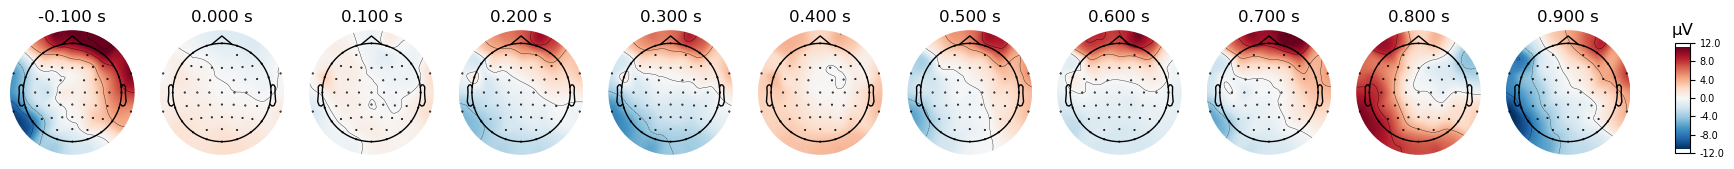

In [54]:
evoked = epochs.average() #mean of the epochs to get the evoked response
evoked.plot(time_unit='s') #plot of the evoked response
evoked.plot_topomap(times=np.linspace(-0.1, 0.9, 11), ch_type='eeg',time_unit='s') #topomap

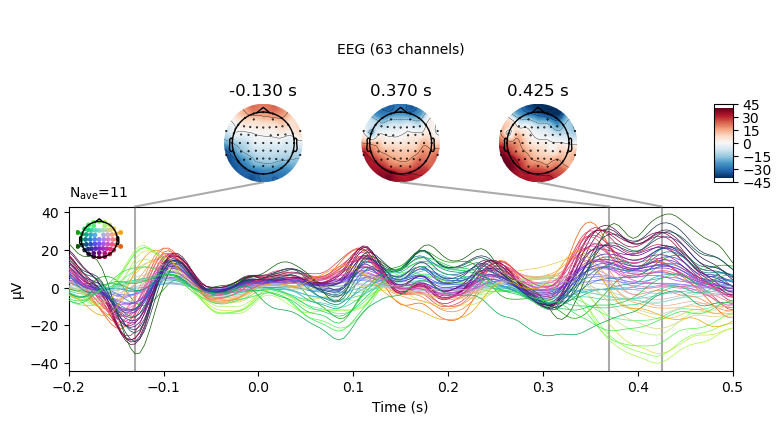

In [37]:
mne.viz.plot_evoked_joint(evoked)